In [38]:
# load conda environment
import sys
sys.path.append("/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/")

from ml_mmpa import master_functions

# data process
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

import seaborn as sns


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import datasets, decomposition
from sklearn.manifold import TSNE

#chem

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, Descriptors3D, Draw, rdMolDescriptors, Draw, PandasTools
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat
from rdkit.Chem.Draw import IPythonConsole

# Initial set up

## Importing master dataset

In [39]:
# import master inhibition data
inhibition = pd.read_csv('data/CO-ADD_InhibitionData_r03_01-02-2020_CSV.csv', low_memory=False)

In [40]:
# check strains avilable in organism == e. coli
inhibition[inhibition['ORGANISM'] == 'Escherichia coli'].STRAIN.value_counts()

ATCC 25922      82517
lpxC; MB4902    81058
tolC; MB5747    74177
Name: STRAIN, dtype: int64

In [41]:
# one compound has outlying values of -213.7 and -278.75 and -329.47 for WT,  tolC and lpxC respectivley, it skews data, I will drop it.

inhibition = inhibition[inhibition.SMILES != 'S(O)(=O)(=O)c1ccccc1\\C(\\c(cc(C)c(c2Br)O)c2)=C(\\C=C3C)/C=C(C3=O)Br']


In [42]:
# define subsets: 

e_coli_wild = inhibition[(inhibition['ORGANISM']=='Escherichia coli') & (inhibition['STRAIN']=='ATCC 25922')][['SMILES', 'INHIB_AVE']].groupby('SMILES').mean().reset_index()

e_coli_efflux = inhibition[(inhibition['ORGANISM']=='Escherichia coli') & (inhibition['STRAIN']=='tolC; MB5747')][['SMILES', 'INHIB_AVE']].groupby('SMILES').mean().reset_index()

e_coli_pore = inhibition[(inhibition['ORGANISM']=='Escherichia coli') & (inhibition['STRAIN']=='lpxC; MB4902')][['SMILES', 'INHIB_AVE']].groupby('SMILES').mean().reset_index()

In [43]:
# collect overlping data:

e_coli_wild_efflux = e_coli_wild[['SMILES', 'INHIB_AVE']].merge(e_coli_efflux[['SMILES', 'INHIB_AVE']],  on='SMILES', suffixes=('_wild', '_efflux'))
e_coli_wild_perm = e_coli_wild[['SMILES', 'INHIB_AVE']].merge(e_coli_pore[['SMILES', 'INHIB_AVE']], on='SMILES', suffixes=('_wild', '_lpxC'))

## Plotting WT vs tolC

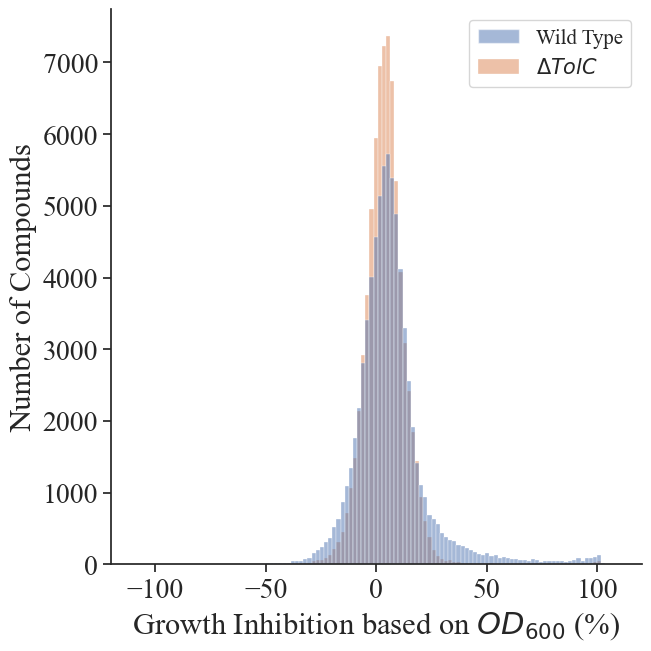

In [44]:
# e_coli_wild_efflux[['INHIB_AVE_wild', 'INHIB_AVE_efflux']].plot.hist(bins=200, alpha=0.5, figsize=[10,7])


# sns.set(rc={"figure.figsize":(10, 7)})

fig, ax = plt.subplots(figsize=(7,7))


sns.set(context='notebook', style='ticks', font='Times New Roman', font_scale=1.9, rc=None)

sns.histplot(e_coli_wild_efflux[['INHIB_AVE_efflux', 'INHIB_AVE_wild']], alpha=0.5, bins=150)

plt.legend(labels = ['Wild Type', '$\Delta TolC$'],  fontsize=15)

plt.xlim([-120, 120])

plt.xlabel('Growth Inhibition based on $OD_{600}$ (%)', fontsize=22);
plt.ylabel('Number of Compounds',  fontsize=22);

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.tight_layout()
sns.despine()


### Paired t-test

In [45]:
# we can now compoute paired t-test to see if removing TolC made a significant difference or not:

stats.ttest_rel(e_coli_wild_efflux['INHIB_AVE_wild'], e_coli_wild_efflux['INHIB_AVE_efflux'])

Ttest_relResult(statistic=-44.099887587864416, pvalue=0.0)

## Defining evaders and substartes

In [46]:
# calculate z-score:
e_coli_wild_efflux['wild_stds'] = stats.zscore(e_coli_wild_efflux.INHIB_AVE_wild)
e_coli_wild_efflux['tolc_stds'] = stats.zscore(e_coli_wild_efflux.INHIB_AVE_efflux)

In [47]:
# label each compounds according to threshold of 4

threshold = 4

def label_it(row):
    if row['wild_stds'] >=threshold:
        return 'active'
    if row['wild_stds'] <threshold:
        return 'inactive'
    
e_coli_wild_efflux['wild_class'] = e_coli_wild_efflux.apply(label_it, axis=1)

def label_it_tolc(row):
    if row['tolc_stds'] >=threshold:
        return 'active'
    if row['tolc_stds'] <threshold:
        return 'inactive'
    
    
e_coli_wild_efflux['tolc_class'] = e_coli_wild_efflux.apply(label_it_tolc, axis=1)

In [48]:
# label compounds based on combination of activity defined above

def label_substrate(row):
    if row['tolc_class'] == 'active' and row['wild_class'] == 'inactive':
        return 'Efflux Substrate'
    if row['tolc_class'] == 'active' and row['wild_class'] == 'active':
        return 'Efflux Evader'
    if row['tolc_class'] == 'inactive' and row['wild_class'] == 'inactive':
        return 'Inactive'
    if row['tolc_class'] == 'inactive' and row['wild_class'] == 'active':
        return 'WT-only Active'

## Resulting Number of classes

In [49]:
# check the numbers of classified data

e_coli_wild_efflux['Class'] = e_coli_wild_efflux.apply(label_substrate, axis=1)
e_coli_wild_efflux.Class.value_counts()

Inactive            72730
Efflux Substrate      760
Efflux Evader         200
WT-only Active         53
Name: Class, dtype: int64

## Scatter Plot

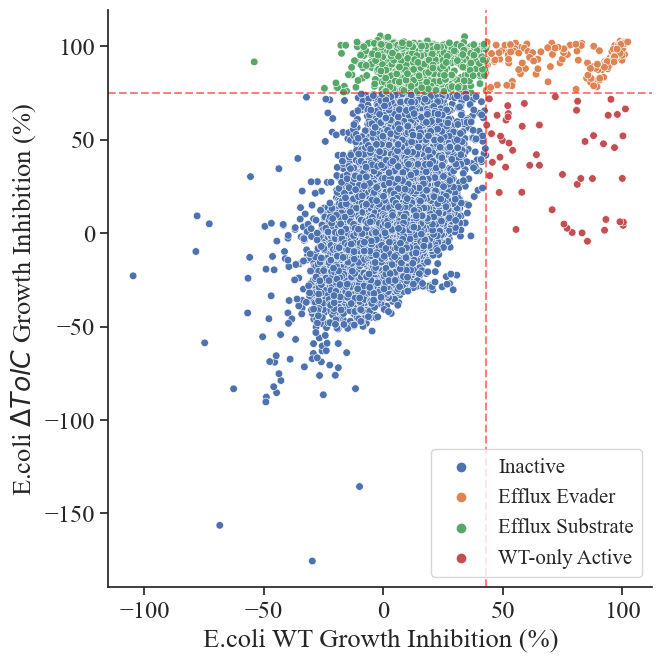

In [50]:
sns.set(rc={"figure.figsize":(7, 7)})

sns.set(context='notebook', style='ticks', font='Times New Roman', font_scale=1.6, rc=None)


sns.scatterplot(data = e_coli_wild_efflux, x='INHIB_AVE_wild', y='INHIB_AVE_efflux', hue='Class', s=30)

sns.despine()

# plt.legend(fontsize=20)

# plt.xlim([-120, 120])

plt.xlabel('E.coli WT Growth Inhibition (%)');

plt.ylabel('E.coli $\Delta TolC$ Growth Inhibition (%)');

# plt.yticks(fontsize=20)
# plt.xticks(fontsize=20)

# plt.axvline(x=43.02,  color='red', linestyle='--', alpha=0.5)
# plt.axhline(y=74.98,  color='red', linestyle='--', alpha=0.5)

plt.axvline(x=e_coli_wild_efflux[e_coli_wild_efflux['wild_stds']>=4].sort_values(by='wild_stds').INHIB_AVE_wild.iloc[0],  color='red', linestyle='--', alpha=0.5)
plt.axhline(y=e_coli_wild_efflux[e_coli_wild_efflux['tolc_stds']>=4].sort_values(by='tolc_stds').INHIB_AVE_efflux.iloc[0],  color='red', linestyle='--', alpha=0.5)

plt.legend(fontsize=15)
plt.tight_layout()

# plt.savefig('figures/wild_tolc_class_scatter.png', dpi=600)

In [51]:
# we can save those datasets seperately

efflux_substrate = e_coli_wild_efflux[e_coli_wild_efflux['Class']=='Efflux Substrate']

efflux_evader = e_coli_wild_efflux[e_coli_wild_efflux['Class']=='Efflux Evader']

wt_only = e_coli_wild_efflux[e_coli_wild_efflux['Class']=='WT-only Active']

inactive = e_coli_wild_efflux[e_coli_wild_efflux['Class']=='Inactive']

## Resulting evaders and substartes

In [52]:
print('No. of resulting evaders: {} \nNo. of resulting substrates: {}'.format(len(efflux_evader), len(efflux_substrate)))

No. of resulting evaders: 200 
No. of resulting substrates: 760


# OM Bias

In [53]:
# import permeating and non-permeating datapoints, they were achived using same process as described above

om_permeating = pd.read_pickle('data_curated/om_permeating.pkl')
om_non_permeating = pd.read_pickle('data_curated/om_non_permeating.pkl')

In [104]:
# to compare the smiles between the two we fisr turn all smiles into same canonical smiles format

efflux_evader['SMILES'] = efflux_evader.SMILES.apply(Chem.CanonSmiles)
efflux_substrate['SMILES'] = efflux_substrate.SMILES.apply(Chem.CanonSmiles)

C:\Users\domin\AppData\Local\Temp\ipykernel_31920\1991868194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efflux_evader['SMILES'] = efflux_evader.SMILES.apply(Chem.CanonSmiles)
C:\Users\domin\AppData\Local\Temp\ipykernel_31920\1991868194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efflux_substrate['SMILES'] = efflux_substrate.SMILES.apply(Chem.CanonSmiles)
[14:34:48] Explicit valence for atom # 2 C, 6, is greater than permitted


ArgumentError: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, int)
did not match C++ signature:
    MolToSmiles(class RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(class RDKit::ROMol mol, struct RDKit::SmilesWriteParams params)

In [55]:
# grab only evaders that are also in OM permeating class
efflux_evaders_om_corrected = efflux_evader[efflux_evader['SMILES'].isin(om_permeating['SMILES'])]

In [56]:
# grab only substrates that are not in non-permeating class
efflux_substrates_om_corrected = efflux_substrate[~efflux_substrate['SMILES'].isin(om_non_permeating['SMILES'])]

## Resulting evaders and substartes

In [20]:
print('No. of resulting evaders: {} \nNo. of resulting substrates: {}'.format(len(efflux_evaders_om_corrected), len(efflux_substrates_om_corrected)))

No. of resulting evaders: 186 
No. of resulting substrates: 554


### Re-defining inactive mols

In [105]:
e_coli_wild_efflux['mol'] = e_coli_wild_efflux.SMILES.apply(Chem.MolFromSmiles)

[14:36:37] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:36:42] Explicit valence for atom # 0 B, 6, is greater than permitted
[14:36:42] Explicit valence for atom # 0 B, 6, is greater than permitted
[14:36:42] Explicit valence for atom # 0 B, 6, is greater than permitted
[14:36:42] Explicit valence for atom # 0 B, 6, is greater than permitted
[14:36:42] Explicit valence for atom # 0 C, 6, is greater than permitted


In [106]:
e_coli_wild_efflux = e_coli_wild_efflux.dropna()

In [107]:
e_coli_wild_efflux['SMILES'] = e_coli_wild_efflux.SMILES.apply(Chem.CanonSmiles)

C:\Users\domin\AppData\Local\Temp\ipykernel_31920\1164120927.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_coli_wild_efflux['SMILES'] = e_coli_wild_efflux.SMILES.apply(Chem.CanonSmiles)


In [114]:
wt_only['mol'] = wt_only.SMILES.apply(Chem.MolFromSmiles)

C:\Users\domin\AppData\Local\Temp\ipykernel_31920\839498751.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wt_only['mol'] = wt_only.SMILES.apply(Chem.MolFromSmiles)


In [115]:
wt_only = wt_only.dropna()

In [116]:
wt_only['SMILES'] = wt_only.SMILES.apply(Chem.CanonSmiles)

In [122]:
# Since efflux evaders and substartes have changed we must redifine inactive molecules, as:
#     Original dataset without evaders and substartes and wt-active only
    
inactive = e_coli_wild_efflux[~e_coli_wild_efflux['SMILES'].isin(efflux_evaders_om_corrected['SMILES'])]

inactive = inactive[~inactive['SMILES'].isin(efflux_substrates_om_corrected['SMILES'])]

inactive = inactive[~inactive['SMILES'].isin(wt_only['SMILES'])]

# t-SNE of evaders vs substartes

In [21]:
# sample of what the dataset currently looks like
efflux_substrates_om_corrected.head(5)

,SMILES,INHIB_AVE_wild,INHIB_AVE_efflux,wild_stds,tolc_stds,wild_class,tolc_class,Class
145,Brc1cncc(-c2cc(NCCCn3ccnc3)nc(-c3ccccc3)n2)c1,4.60,80.47,0.054632,4.326681,inactive,active,Efflux Substrate
308,N#C/C(=N\Nc1cccc(C(F)(F)F)c1)C(N)=S,18.36,87.98,1.468423,4.766621,inactive,active,Efflux Substrate
403,CC(C)C(=O)/C(=C/c1ccc(Cl)cc1Cl)n1cncn1,5.84,97.31,0.182037,5.313179,inactive,active,Efflux Substrate
585,O=C(N/N=C(/CC(=O)c1cccs1)C(F)(F)F)c1cccc([N+](...,-3.58,88.80,-0.785834,4.814658,inactive,active,Efflux Substrate
589,O=C(N/N=C(/CC(=O)c1cccs1)C(F)(F)F)c1ccc(Cl)cc1,20.78,77.14,1.717070,4.131607,inactive,active,Efflux Substrate


In [22]:
# we need to compute fingerprints from SMILES for t-sne:

efflux_evaders_om_corrected['mol'] = efflux_evaders_om_corrected.SMILES.apply(Chem.MolFromSmiles)
efflux_evaders_om_corrected.dropna(subset=['mol'], inplace=True)

efflux_evaders_om_corrected['fps']=efflux_evaders_om_corrected.mol.apply(MACCSkeys.GenMACCSKeys)


# substartes


efflux_substrates_om_corrected['mol'] = efflux_substrates_om_corrected.SMILES.apply(Chem.MolFromSmiles)
efflux_substrates_om_corrected.dropna(subset=['mol'], inplace=True)

efflux_substrates_om_corrected['fps']=efflux_substrates_om_corrected.mol.apply(MACCSkeys.GenMACCSKeys)


C:\Users\domin\AppData\Local\Temp\ipykernel_31920\1773481342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efflux_evaders_om_corrected['mol'] = efflux_evaders_om_corrected.SMILES.apply(Chem.MolFromSmiles)
C:\Users\domin\AppData\Local\Temp\ipykernel_31920\1773481342.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efflux_evaders_om_corrected.dropna(subset=['mol'], inplace=True)
C:\Users\domin\AppData\Local\Temp\ipykernel_31920\1773481342.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [23]:
# combine two datasets and reset index

sub_and_evade_om_corrected = pd.concat([efflux_evaders_om_corrected,efflux_substrates_om_corrected]).reset_index(drop=True)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 740 samples in 0.000s...
[t-SNE] Computed neighbors for 740 samples in 0.134s...
[t-SNE] Computed conditional probabilities for sample 740 / 740
[t-SNE] Mean sigma: 1.233915
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.353088
[t-SNE] KL divergence after 1000 iterations: 0.593206


<Axes: xlabel='TC1', ylabel='TC2'>

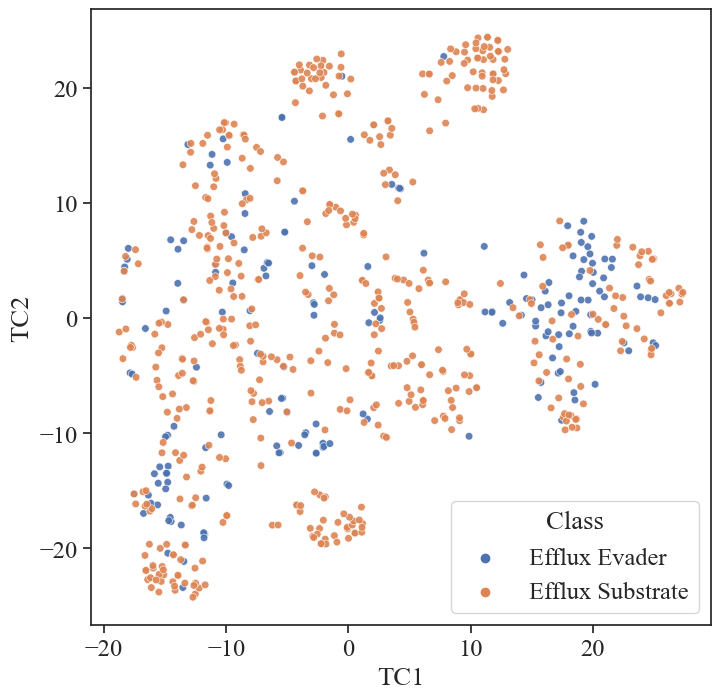

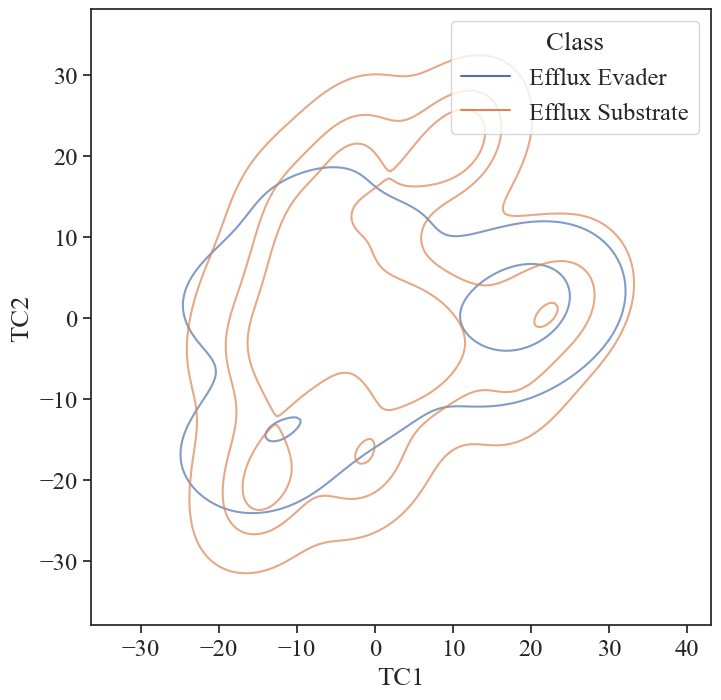

In [24]:
sub_and_evade_om_corrected_tsne = master_functions.tsne_no_plot(sub_and_evade_om_corrected['fps'], perp=50)

fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(x='TC1',y='TC2',data=sub_and_evade_om_corrected_tsne, s=30 ,alpha=0.9, hue=sub_and_evade_om_corrected['Class']) 

fig, ax = plt.subplots(figsize=(8,8))

sns.kdeplot(x='TC1',y='TC2',data=sub_and_evade_om_corrected_tsne,alpha=0.7, hue=sub_and_evade_om_corrected['Class'], levels = 4)

We find some overlapping compounds

# PCA of evaders and substrates

In [25]:
def calcualte_features_single(df, col):
    generator = MakeGenerator(("rdkit2d",))
    names=[name[0] for name in  generator.GetColumns()]
    
    l_feat=[]
    
    print('Computing features: ')
    
    for i in trange(len(df[col].values)):
        l_data = generator.process(df[col].values[i])
        
        if l_data[0]  == True:
            l_feat.append(l_data[1:])
        else:
            print('left: ', l_data[0])
            print(df[col].values[i])
    

    # add descriptors to existing dataframe 
    feats = pd.DataFrame()
    
    for i in trange(len(l_feat)):
        feats = feats.append(pd.Series(l_feat[i]), ignore_index=True)
    
    for i in trange(len(l_feat)):
        feats = feats.append(pd.Series(l_feat[i]), ignore_index=True)
        feats = pd.concat([feats, ])
    feats.columns = names[1:]

    return feats

In [26]:
sub_and_evade_features = master_functions.calcualte_features_single(sub_and_evade_om_corrected, 'SMILES')
sub_and_evade_features['Class'] = sub_and_evade_om_corrected['Class']

Computing features: 


  0%|                                                                                          | 0/740 [00:00<?, ?it/s]H:\My Drive\co_add_jupyter\ml_mmpa\master_functions.py:235: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feats = feats.append(pd.Series(l_feat[i]), ignore_index=True)
H:\My Drive\co_add_jupyter\ml_mmpa\master_functions.py:235: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feats = feats.append(pd.Series(l_feat[i]), ignore_index=True)
H:\My Drive\co_add_jupyter\ml_mmpa\master_functions.py:235: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feats = feats.append(pd.Series(l_feat[i]), ignore_index=True)
H:\My Drive\co_add_jupyter\ml_mmpa\master_functions.py:235: FutureWarning: The frame.append method is deprecat

In [27]:
# sub_and_evade_features = master_functions.calc_feats(sub_and_evade_om_corrected['mol'])
# sub_and_evade_features['Class'] = sub_and_evade_om_corrected['Class']

In [28]:
# drop feature columns that contain Nans, its only 4 columns

sub_and_evade_features=sub_and_evade_features.dropna(axis=1)

In [ ]:
# pca on all physcicochemical features:

table = sub_and_evade_features

#The non-redundant molecular descriptors chosen for PCA

descriptors  = table.iloc[:,:-87]

descriptors_std = StandardScaler().fit_transform(descriptors) #Important to avoid scaling problems between our different descriptors
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)
descriptors_pca= pd.DataFrame(descriptors_2d) # Saving PCA values to a new table
descriptors_pca.index = table.index
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
descriptors_pca.head(5) #Displays the PCA table

scale1 = 1.0/(max(descriptors_pca['PC1']) - min(descriptors_pca['PC1'])) 
scale2 = 1.0/(max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))

# And we add the new values to our PCA table
descriptors_pca['PC1_normalized']=[i*scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized']=[i*scale2 for i in descriptors_pca['PC2']]


descriptors_pca['Class'] = sub_and_evade_features['Class']


# plt.rcParams['axes.linewidth'] = 1.5


cmap = sns.diverging_palette(133, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(10,5))

sns.scatterplot(x='PC1',y='PC2',data=descriptors_pca, alpha=0.7, hue='Class', s=20)#, palette=["C0", "C1", "C2", "k"])


pca_lab = ('PC1 '+str([np.round(pca.explained_variance_ratio_[0]*100, 1)]), 'PC2 '+str([np.round(pca.explained_variance_ratio_[1]*100, 1)]))


plt.xlabel(pca_lab[0],fontsize=16,fontweight='bold')
plt.ylabel(pca_lab[1],fontsize=16,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

plt.tight_layout()

# plt.savefig('figures/pca_evade_substrate.png', dpi=600)

plt.show()

print('same but in contours, for ease of read')

cmap = sns.diverging_palette(133, 10, as_cmap=True)


############ kdeplot


fig, ax = plt.subplots(figsize=(10,7))

sns.set_style("ticks")

# sns.set(font_scale=2)

sns.kdeplot(x='PC1',y='PC2',data=descriptors_pca, hue='Class' , levels=3,)


pca_lab= ('PC1 '+str([np.round(pca.explained_variance_ratio_[0]*100, 1)]), 'PC2 '+str([np.round(pca.explained_variance_ratio_[1]*100, 1)]))


plt.xlabel(pca_lab[0],fontweight='bold',fontsize=22)
plt.ylabel(pca_lab[1],fontweight='bold', fontsize=22)

plt.tick_params ('both',width=2,labelsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

# plt.legend()

plt.tight_layout()

# plt.savefig('figures/pca_evade_substrate_contour.png', dpi=600)

explained variance is too low, I will chose only 6 mian features for PCA next:

In [ ]:
# pca on only 6 main physcicochemical features:

table = sub_and_evade_features

#The non-redundant molecular descriptors chosen for PCA

descriptors = table[['MolWt', 'MolLogP','NumHeteroatoms','RingCount','FractionCSP3', 'TPSA']].values

# descriptors  = table.iloc[:,:-87]

descriptors_std = StandardScaler().fit_transform(descriptors) #Important to avoid scaling problems between our different descriptors
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)
descriptors_pca= pd.DataFrame(descriptors_2d) # Saving PCA values to a new table
descriptors_pca.index = table.index
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
descriptors_pca.head(5) #Displays the PCA table

scale1 = 1.0/(max(descriptors_pca['PC1']) - min(descriptors_pca['PC1'])) 
scale2 = 1.0/(max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))

# And we add the new values to our PCA table
descriptors_pca['PC1_normalized']=[i*scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized']=[i*scale2 for i in descriptors_pca['PC2']]


descriptors_pca['Class'] = sub_and_evade_features['Class']


# plt.rcParams['axes.linewidth'] = 1.5


cmap = sns.diverging_palette(133, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(10,5))

sns.scatterplot(x='PC1',y='PC2',data=descriptors_pca, alpha=0.7, hue='Class', s=20)#, palette=["C0", "C1", "C2", "k"])


pca_lab = ('PC1 '+str([np.round(pca.explained_variance_ratio_[0]*100, 1)]), 'PC2 '+str([np.round(pca.explained_variance_ratio_[1]*100, 1)]))


plt.xlabel(pca_lab[0],fontsize=16,fontweight='bold')
plt.ylabel(pca_lab[1],fontsize=16,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

plt.tight_layout()

# plt.savefig('figures/pca_evade_substrate.png', dpi=600)

plt.show()

print('same but in contours, for ease of read')

cmap = sns.diverging_palette(133, 10, as_cmap=True)


############ kdeplot


fig, ax = plt.subplots(figsize=(10,7))

sns.set_style("ticks")

# sns.set(font_scale=2)

sns.kdeplot(x='PC1',y='PC2',data=descriptors_pca, hue='Class' , levels=3,)


pca_lab= ('PC1 '+str([np.round(pca.explained_variance_ratio_[0]*100, 1)]), 'PC2 '+str([np.round(pca.explained_variance_ratio_[1]*100, 1)]))


plt.xlabel(pca_lab[0],fontweight='bold',fontsize=22)
plt.ylabel(pca_lab[1],fontweight='bold', fontsize=22)

plt.tick_params ('both',width=2,labelsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

# plt.legend()

plt.tight_layout()

# plt.savefig('figures/pca_evade_substrate_contour.png', dpi=600)

similar result where exlpained variance is about 70% but classes are still not seperated at all

# MMPA

To carry out mmpa I used modified mmpdb : https://github.com/rdkit/mmpdb

publication : https://doi.org/10.1021/acs.jcim.8b00173

In [63]:
# import results from MMPA: 

efflux_mmpa_index = pd.read_pickle('data_curated/efflux_mmpa_index.pkl')

# it cntains 1.4M pairs

# Evader Transforms

In [36]:
def clean_mmpa_pairs_len(mmpa_df):
    temp=pd.DataFrame() # temp dataframe
    if 'LHS' not in mmpa_df.columns: # add LHS and RHS if not present
        mmpa_df = master_functions.split_transition(mmpa_df, 'smirks')     # produce LHS and RHS
    else:
        temp['common_core_HA'] = mmpa_df['common_core'].apply(mols_to_NHA) # produce number of heavy atoms
        temp['LHS_HA'] = mmpa_df['LHS'].apply(mols_to_NHA)
        temp['RHS_HA'] = mmpa_df['LHS'].apply(mols_to_NHA)
        
        temp['len_check'] = np.where((temp['LHS_HA'] >= temp['common_core_HA']) & (temp['RHS_HA'] >= temp['common_core_HA'])
                     , 'fail', 'pass') # compare lengths of heavy atoms
        
        mmpa_df = mmpa_df.drop(temp[temp['len_check']=='fail'].index) # drop index that failed length check
        
        print('Initial number of transofrms: {} \nNumber fo transforms disqualified based on length discrepancy: {} \nRemaining number of transforms: {}'.format(len(temp[temp['len_check']=='fail']) +  len(mmpa_df) , len(temp[temp['len_check']=='fail']), len(mmpa_df)))
        # return temp to debug
    return mmpa_df

In [64]:
# Clean the pairs according to our criteria:


In [72]:
inactive['mol'] = inactive.SMILES.apply(Chem.MolFromSmiles)

[13:41:42] Explicit valence for atom # 2 C, 6, is greater than permitted
[13:41:46] Explicit valence for atom # 0 B, 6, is greater than permitted
[13:41:46] Explicit valence for atom # 0 B, 6, is greater than permitted
[13:41:46] Explicit valence for atom # 0 B, 6, is greater than permitted
[13:41:46] Explicit valence for atom # 0 B, 6, is greater than permitted
[13:41:46] Explicit valence for atom # 0 C, 6, is greater than permitted
C:\Users\domin\AppData\Local\Temp\ipykernel_31920\361678754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inactive['mol'] = inactive.SMILES.apply(Chem.MolFromSmiles)


In [75]:
inactive = inactive.dropna(subset=['mol'])
inactive.reset_index(drop=True, inplace=True)

In [76]:
inactive['SMILES'] = inactive.SMILES.apply(Chem.CanonSmiles)

In [125]:
# find evader transforms:

evader_transforms = efflux_mmpa_index[(efflux_mmpa_index['compound_structure_B'].isin(efflux_evaders_om_corrected.SMILES)) & (efflux_mmpa_index['compound_structure_A'].isin(inactive.SMILES))]

evader_transforms = master_functions.clean_mmpa_pairs_len(evader_transforms)

Initial number of transofrms: 2468 
Number fo transforms disqualified based on length discrepancy: 1856 
Remaining number of transforms: 612


In [131]:
len(evader_transforms.compound_structure_B.unique())

77

In [133]:
len(evader_transforms.compound_structure_A.unique())

397

# Substrate Transforms

In [129]:
substrate_transforms = efflux_mmpa_index[(efflux_mmpa_index['compound_structure_B'].isin(efflux_substrates_om_corrected.SMILES)) & (efflux_mmpa_index['compound_structure_A'].isin(inactive.SMILES)) ]

substrate_transforms = master_functions.clean_mmpa_pairs_len(substrate_transforms)

Initial number of transofrms: 6827 
Number fo transforms disqualified based on length discrepancy: 1927 
Remaining number of transforms: 4900


In [134]:
len(substrate_transforms.compound_structure_A.unique())

2053

In [132]:
len(substrate_transforms.compound_structure_B.unique())

349

In [136]:
substrate_transforms.reset_index(drop=True, inplace=True)

In [137]:
evader_transforms.reset_index(drop=True, inplace=True)

In [139]:
substrate_transforms.to_csv('substrate_transforms.csv', index=False)

In [140]:
evader_transforms.to_csv('evader_transforms.csv', index=False)

# CHASER on Transfroms

# Tripple Transforms